In [1]:
#import packages
import numpy as np # linear algebra
import pandas as pd # data processing
import torch 
import torch.nn as nn
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import seaborn as sns

#load and print data
data = pd.read_csv('../input/synchronous-machine-dataset/SynchronousMachine.csv')
print(data.head())

   I_y    PF  e_PF   d_if    I_f
0  3.0  0.66  0.34  0.383  1.563
1  3.0  0.68  0.32  0.372  1.552
2  3.0  0.70  0.30  0.360  1.540
3  3.0  0.72  0.28  0.338  1.518
4  3.0  0.74  0.26  0.317  1.497


In [2]:
data.describe()

,I_y,PF,e_PF,d_if,I_f
count,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.499820,0.825296,0.174704,0.350659,1.530659
std,0.896024,0.103925,0.103925,0.180566,0.180566
min,3.000000,0.650000,0.000000,0.037000,1.217000
25%,3.700000,0.740000,0.080000,0.189000,1.369000
50%,4.500000,0.820000,0.180000,0.345000,1.525000
75%,5.300000,0.920000,0.260000,0.486000,1.666000
max,6.000000,1.000000,0.350000,0.769000,1.949000


<AxesSubplot:title={'center':'Plot of power factor and excitation current of synchronous machine'}>

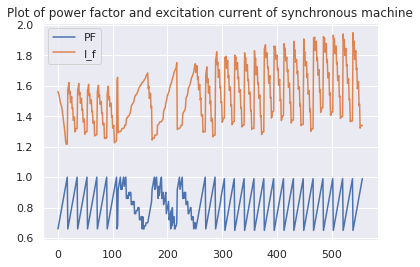

In [3]:
%matplotlib inline
sns.set()
data.plot(y=['PF', 'I_f'], title='Plot of power factor and excitation current of synchronous machine')

In [4]:
y = data['I_f']
x = data.drop(['I_f'], axis=1)
x = torch.from_numpy(x.values).float() 
y = torch.from_numpy(y.values).float()

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(x)

y=y.reshape(-1,1)
y_mm = mm.fit_transform(y) 

In [6]:
#split dataset to train and test sets
test_size = int(0.1 * len(X_ss))
x_train = X_ss[:-test_size]
x_test = X_ss[-test_size:]

y_train = y_mm[:-test_size]
y_test = y_mm[-test_size:]

In [7]:
print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape) 

Training Shape (502, 4) (502, 1)
Testing Shape (55, 4) (55, 1)


In [8]:
X_train_tensors = Variable(torch.Tensor(x_train))
X_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [9]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [10]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([502, 1, 4]) torch.Size([502, 1])
Testing Shape torch.Size([55, 1, 4]) torch.Size([55, 1])


In [11]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [12]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [13]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [14]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [15]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06828
Epoch: 100, loss: 0.00304
Epoch: 200, loss: 0.00094
Epoch: 300, loss: 0.00045
Epoch: 400, loss: 0.00023
Epoch: 500, loss: 0.00015
Epoch: 600, loss: 0.00011
Epoch: 700, loss: 0.00009
Epoch: 800, loss: 0.00007
Epoch: 900, loss: 0.00006


In [16]:
df_X_ss = ss.transform(data.drop(['I_f'], axis=1)) #old transformers
df_y_mm = mm.transform(data['I_f'].values.reshape(-1, 1)) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

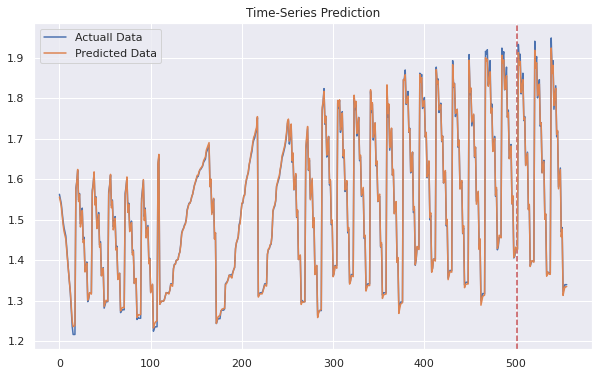

In [17]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=502, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 